# Plant Seedlings Classification - Tensorflow Project

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import glob
from IPython.display import Image
import cv2

In [2]:
print("Tensorflow Version",tf.__version__)

Tensorflow Version 1.3.0


In [3]:
IMG_SIZE = (51, 51)
COLOR_CHANNELS = 3

## Augmentation Functions

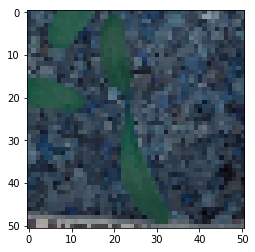

In [4]:
sample = cv2.resize(cv2.imread('../data/SeedlingData/train/Sugar beet/1347ac5ac.png'), IMG_SIZE)
plt.imshow(sample)

In [5]:
def histogram_equalize(img):
    if(COLOR_CHANNELS == 1):
        return cv2.equalizeHist(img)
        
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

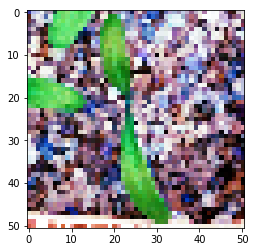

In [6]:
sample = histogram_equalize(sample)
plt.imshow(sample)

In [7]:
def random_rotate(img):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), random.randrange(360), 1)
    img_rotation = cv2.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return img_rotation

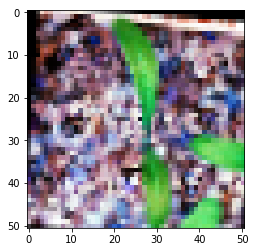

In [8]:
sample = random_rotate(sample)
plt.imshow(sample)

In [9]:
def random_zoom(img):
    x1, y1 = random.randrange(0, 5), random.randrange(0, 5)
    x2, y2 = random.randrange(45, 51), random.randrange(45, 51)
    img = img[y1:y2, x1:x2]
    img = cv2.resize(img, IMG_SIZE)
    return img

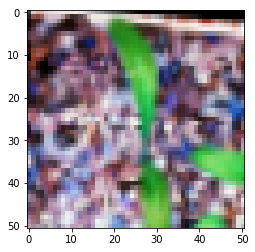

In [10]:
sample = random_zoom(sample)
plt.imshow(sample)

## Data

### - One Hot labels

In [11]:
dirs = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
       'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
values = np.array(dirs)
# print(values,'\n')

#transformando em one hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encodeded = np.array(onehot_encoder.fit_transform(integer_encoded)).astype(int)
# print(onehot_encodeded)

### - Training Data

In [12]:
training_path = '../data/SeedlingData/train/'
training_data = []
__ = -1;
for img_class in dirs:
    __ += 1
    for filename in glob.glob(training_path+img_class+'/*.png'):
        im = cv2.imread(filename)
        im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE)))
        training_data.append([im, onehot_encodeded[__]])
random.shuffle(training_data)

### Cross Validation - Validation Data

In [13]:
print(len(training_data))
validation_data, validation_label = [], []
validation_set_percentage = 0.15
validation = training_data[-int(validation_set_percentage*len(training_data)):]
training_data = training_data[:-int(validation_set_percentage*len(training_data))]
for i in range(len(validation)):
    validation_data.append(validation[i][0].ravel())
    validation_label.append(validation[i][1])

4750


### - Test Data

In [14]:
test_path = '../data/SeedlingData/test/'
test_data = []
for filename in glob.glob(test_path+'/*.png'):
    im = cv2.imread(filename)
    im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE))).ravel()
    test_data.append([im, filename.split('/')[-1]])

### Building Model

In [15]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(init_random_dist)

In [16]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [17]:
def conv2d(x, W):
    #x -> [batch, H, W, Channels]
    #W -> [filter H, filter W, Channels IN, Channels Out]
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [18]:
def max_pool_2by2(x):
    #x -> [batch, H, W, Channels]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides = [1,2,2,1], padding='SAME')

In [19]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

In [20]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [21]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE[0]*IMG_SIZE[1]*COLOR_CHANNELS])
y_ = tf.placeholder(tf.float32, shape=[None, 12])

In [22]:
#layers
x_image = tf.reshape(x, [-1, IMG_SIZE[0], IMG_SIZE[1], COLOR_CHANNELS])

In [23]:
convo_1 = convolutional_layer(x_image, shape=[5,5,COLOR_CHANNELS,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [24]:
convo_2 = convolutional_layer(convo_1_pooling, shape=[5,5,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [25]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 13*13*64])

In [26]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [27]:
#dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [28]:
y_pred = normal_full_layer(full_one_dropout, 12)

In [29]:
#Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))

In [30]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

## Batch Loader

In [31]:
def load_batch(size):
    batch_x, batch_y = [],[]
    for _ in range(size):
            rand_val = random.randrange(0,len(test_data))
            batch_x.append(random_zoom(random_rotate(training_data[rand_val][0])).ravel())
            batch_y.append(training_data[rand_val][1])
    return batch_x, batch_y    

## Runing Session

In [32]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [33]:
steps = 300000

In [34]:
plot_data = []
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size)
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        feed = {x:batch_x, y_:batch_y, hold_prob:0.5}
        sess.run(train, feed_dict = feed)
        
        if i%100 == 0:
            temp_plot = sess.run(cross_entropy, feed_dict = feed)
            
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            accuracy = sess.run(acc, feed_dict={x:validation_data, y_:validation_label, hold_prob:1.0})
            plot_data.append([temp_plot, accuracy])
            
            print('>  ON STEP: {:8} - COST: {: 16.6f} - ACCURACY: {: >#16.6f}'.format(i, temp_plot, accuracy))
            
    #saving trained model
    save_path = saver.save(sess, "./seedlings-model.ckpt")
    print("Model saved in path: %s" % save_path)

>  ON STEP:        0 - COST:     11549.384766 - ACCURACY:         0.058989
>  ON STEP:      100 - COST:        11.235839 - ACCURACY:         0.108146
>  ON STEP:      200 - COST:         3.938520 - ACCURACY:         0.125000
>  ON STEP:      300 - COST:         3.226871 - ACCURACY:         0.122191
>  ON STEP:      400 - COST:         2.689063 - ACCURACY:         0.125000
>  ON STEP:      500 - COST:         2.435423 - ACCURACY:         0.126404
>  ON STEP:      600 - COST:         2.557839 - ACCURACY:         0.126404
>  ON STEP:      700 - COST:         2.370143 - ACCURACY:         0.125000
>  ON STEP:      800 - COST:         2.430769 - ACCURACY:         0.126404
>  ON STEP:      900 - COST:         2.400021 - ACCURACY:         0.126404
>  ON STEP:     1000 - COST:         2.400417 - ACCURACY:         0.126404
>  ON STEP:     1100 - COST:         2.464186 - ACCURACY:         0.126404
>  ON STEP:     1200 - COST:         2.402089 - ACCURACY:         0.126404
>  ON STEP:     1300 - CO

>  ON STEP:    11000 - COST:         2.420375 - ACCURACY:         0.126404
>  ON STEP:    11100 - COST:         2.323559 - ACCURACY:         0.126404
>  ON STEP:    11200 - COST:         2.398843 - ACCURACY:         0.126404
>  ON STEP:    11300 - COST:         2.429213 - ACCURACY:         0.126404
>  ON STEP:    11400 - COST:         2.380768 - ACCURACY:         0.126404
>  ON STEP:    11500 - COST:         2.435388 - ACCURACY:         0.126404
>  ON STEP:    11600 - COST:         2.316942 - ACCURACY:         0.126404
>  ON STEP:    11700 - COST:         2.341723 - ACCURACY:         0.126404
>  ON STEP:    11800 - COST:         2.323589 - ACCURACY:         0.126404
>  ON STEP:    11900 - COST:         2.308602 - ACCURACY:         0.126404
>  ON STEP:    12000 - COST:         2.340831 - ACCURACY:         0.126404
>  ON STEP:    12100 - COST:         2.291430 - ACCURACY:         0.126404
>  ON STEP:    12200 - COST:         2.449749 - ACCURACY:         0.126404
>  ON STEP:    12300 - CO

>  ON STEP:    22000 - COST:         1.956076 - ACCURACY:         0.244382
>  ON STEP:    22100 - COST:         1.880848 - ACCURACY:         0.258427
>  ON STEP:    22200 - COST:         2.146761 - ACCURACY:         0.179775
>  ON STEP:    22300 - COST:         1.946359 - ACCURACY:         0.247191
>  ON STEP:    22400 - COST:         1.984059 - ACCURACY:         0.252809
>  ON STEP:    22500 - COST:         1.946992 - ACCURACY:         0.230337
>  ON STEP:    22600 - COST:         1.922158 - ACCURACY:         0.262640
>  ON STEP:    22700 - COST:         1.962473 - ACCURACY:         0.257022
>  ON STEP:    22800 - COST:         2.087199 - ACCURACY:         0.223315
>  ON STEP:    22900 - COST:         1.964038 - ACCURACY:         0.255618
>  ON STEP:    23000 - COST:         2.272046 - ACCURACY:         0.254213
>  ON STEP:    23100 - COST:         1.933706 - ACCURACY:         0.213483
>  ON STEP:    23200 - COST:         1.915106 - ACCURACY:         0.212079
>  ON STEP:    23300 - CO

>  ON STEP:    33000 - COST:         1.871064 - ACCURACY:         0.223315
>  ON STEP:    33100 - COST:         2.031823 - ACCURACY:         0.269663
>  ON STEP:    33200 - COST:         1.900612 - ACCURACY:         0.286517
>  ON STEP:    33300 - COST:         1.753963 - ACCURACY:         0.191011
>  ON STEP:    33400 - COST:         1.851235 - ACCURACY:         0.224719
>  ON STEP:    33500 - COST:         1.935984 - ACCURACY:         0.259831
>  ON STEP:    33600 - COST:         2.000646 - ACCURACY:         0.245787
>  ON STEP:    33700 - COST:         1.835682 - ACCURACY:         0.286517
>  ON STEP:    33800 - COST:         2.020714 - ACCURACY:         0.254213
>  ON STEP:    33900 - COST:         1.923437 - ACCURACY:         0.276685
>  ON STEP:    34000 - COST:         1.810907 - ACCURACY:         0.278090
>  ON STEP:    34100 - COST:         1.928724 - ACCURACY:         0.292135
>  ON STEP:    34200 - COST:         1.982419 - ACCURACY:         0.255618
>  ON STEP:    34300 - CO

>  ON STEP:    44000 - COST:         1.732583 - ACCURACY:         0.362360
>  ON STEP:    44100 - COST:         1.319217 - ACCURACY:         0.394663
>  ON STEP:    44200 - COST:         1.540105 - ACCURACY:         0.369382
>  ON STEP:    44300 - COST:         1.448344 - ACCURACY:         0.372191
>  ON STEP:    44400 - COST:         1.246045 - ACCURACY:         0.411517
>  ON STEP:    44500 - COST:         1.554358 - ACCURACY:         0.379213
>  ON STEP:    44600 - COST:         1.136481 - ACCURACY:         0.382023
>  ON STEP:    44700 - COST:         1.654600 - ACCURACY:         0.401685
>  ON STEP:    44800 - COST:         1.459752 - ACCURACY:         0.400281
>  ON STEP:    44900 - COST:         1.537454 - ACCURACY:         0.386236
>  ON STEP:    45000 - COST:         1.430534 - ACCURACY:         0.391854
>  ON STEP:    45100 - COST:         1.419810 - ACCURACY:         0.342697
>  ON STEP:    45200 - COST:         1.278602 - ACCURACY:         0.338483
>  ON STEP:    45300 - CO

>  ON STEP:    55000 - COST:         0.435366 - ACCURACY:         0.622191
>  ON STEP:    55100 - COST:         1.090487 - ACCURACY:         0.627809
>  ON STEP:    55200 - COST:         0.670048 - ACCURACY:         0.639045
>  ON STEP:    55300 - COST:         0.697571 - ACCURACY:         0.643258
>  ON STEP:    55400 - COST:         0.906770 - ACCURACY:         0.608146
>  ON STEP:    55500 - COST:         0.558877 - ACCURACY:         0.615169
>  ON STEP:    55600 - COST:         1.060561 - ACCURACY:         0.626404
>  ON STEP:    55700 - COST:         0.585835 - ACCURACY:         0.596910
>  ON STEP:    55800 - COST:         0.407321 - ACCURACY:         0.619382
>  ON STEP:    55900 - COST:         0.774918 - ACCURACY:         0.595506
>  ON STEP:    56000 - COST:         0.547560 - ACCURACY:         0.643258
>  ON STEP:    56100 - COST:         0.688296 - ACCURACY:         0.603933
>  ON STEP:    56200 - COST:         0.622288 - ACCURACY:         0.634831
>  ON STEP:    56300 - CO

>  ON STEP:    66000 - COST:         0.738270 - ACCURACY:         0.623596
>  ON STEP:    66100 - COST:         0.477454 - ACCURACY:         0.675562
>  ON STEP:    66200 - COST:         0.343051 - ACCURACY:         0.651685
>  ON STEP:    66300 - COST:         0.434167 - ACCURACY:         0.661517
>  ON STEP:    66400 - COST:         0.304723 - ACCURACY:         0.660112
>  ON STEP:    66500 - COST:         0.334000 - ACCURACY:         0.655899
>  ON STEP:    66600 - COST:         0.445486 - ACCURACY:         0.630618
>  ON STEP:    66700 - COST:         0.722230 - ACCURACY:         0.660112
>  ON STEP:    66800 - COST:         0.554549 - ACCURACY:         0.643258
>  ON STEP:    66900 - COST:         0.378316 - ACCURACY:         0.647472
>  ON STEP:    67000 - COST:         0.437289 - ACCURACY:         0.662921
>  ON STEP:    67100 - COST:         0.466474 - ACCURACY:         0.679775
>  ON STEP:    67200 - COST:         0.705952 - ACCURACY:         0.641854
>  ON STEP:    67300 - CO

>  ON STEP:    77000 - COST:         0.521732 - ACCURACY:         0.646067
>  ON STEP:    77100 - COST:         0.510794 - ACCURACY:         0.647472
>  ON STEP:    77200 - COST:         0.451982 - ACCURACY:         0.664326
>  ON STEP:    77300 - COST:         0.509401 - ACCURACY:         0.667135
>  ON STEP:    77400 - COST:         0.249151 - ACCURACY:         0.678371
>  ON STEP:    77500 - COST:         0.262919 - ACCURACY:         0.660112
>  ON STEP:    77600 - COST:         0.628718 - ACCURACY:         0.689607
>  ON STEP:    77700 - COST:         0.516008 - ACCURACY:         0.668539
>  ON STEP:    77800 - COST:         1.998756 - ACCURACY:         0.401685
>  ON STEP:    77900 - COST:         0.551388 - ACCURACY:         0.636236
>  ON STEP:    78000 - COST:         0.603729 - ACCURACY:         0.633427
>  ON STEP:    78100 - COST:         0.472540 - ACCURACY:         0.657303
>  ON STEP:    78200 - COST:         0.944634 - ACCURACY:         0.683989
>  ON STEP:    78300 - CO

>  ON STEP:    88000 - COST:         0.450810 - ACCURACY:         0.696629
>  ON STEP:    88100 - COST:         0.137110 - ACCURACY:         0.633427
>  ON STEP:    88200 - COST:         0.340296 - ACCURACY:         0.651685
>  ON STEP:    88300 - COST:         0.607335 - ACCURACY:         0.643258
>  ON STEP:    88400 - COST:         0.373963 - ACCURACY:         0.644663
>  ON STEP:    88500 - COST:         0.398428 - ACCURACY:         0.657303
>  ON STEP:    88600 - COST:         0.402059 - ACCURACY:         0.675562
>  ON STEP:    88700 - COST:         0.329423 - ACCURACY:         0.654494
>  ON STEP:    88800 - COST:         0.435304 - ACCURACY:         0.661517
>  ON STEP:    88900 - COST:         0.247857 - ACCURACY:         0.657303
>  ON STEP:    89000 - COST:         0.353564 - ACCURACY:         0.651685
>  ON STEP:    89100 - COST:         0.305606 - ACCURACY:         0.662921
>  ON STEP:    89200 - COST:         0.906510 - ACCURACY:         0.643258
>  ON STEP:    89300 - CO

>  ON STEP:    99000 - COST:         0.188629 - ACCURACY:         0.658708
>  ON STEP:    99100 - COST:         0.628461 - ACCURACY:         0.679775
>  ON STEP:    99200 - COST:         0.547971 - ACCURACY:         0.668539
>  ON STEP:    99300 - COST:         0.384199 - ACCURACY:         0.639045
>  ON STEP:    99400 - COST:         0.227908 - ACCURACY:         0.662921
>  ON STEP:    99500 - COST:         0.331156 - ACCURACY:         0.683989
>  ON STEP:    99600 - COST:         0.110748 - ACCURACY:         0.678371
>  ON STEP:    99700 - COST:         0.346464 - ACCURACY:         0.676966
>  ON STEP:    99800 - COST:         0.498677 - ACCURACY:         0.675562
>  ON STEP:    99900 - COST:         0.393423 - ACCURACY:         0.674157
>  ON STEP:   100000 - COST:         0.437734 - ACCURACY:         0.667135
>  ON STEP:   100100 - COST:         0.435821 - ACCURACY:         0.665730
>  ON STEP:   100200 - COST:         0.237948 - ACCURACY:         0.667135
>  ON STEP:   100300 - CO

>  ON STEP:   110000 - COST:         0.433118 - ACCURACY:         0.668539
>  ON STEP:   110100 - COST:         0.752127 - ACCURACY:         0.636236
>  ON STEP:   110200 - COST:         0.252344 - ACCURACY:         0.674157
>  ON STEP:   110300 - COST:         0.326331 - ACCURACY:         0.640449
>  ON STEP:   110400 - COST:         0.426169 - ACCURACY:         0.667135
>  ON STEP:   110500 - COST:         0.397703 - ACCURACY:         0.692416
>  ON STEP:   110600 - COST:         0.342410 - ACCURACY:         0.661517
>  ON STEP:   110700 - COST:         0.488562 - ACCURACY:         0.658708
>  ON STEP:   110800 - COST:         0.224182 - ACCURACY:         0.674157
>  ON STEP:   110900 - COST:         0.588059 - ACCURACY:         0.675562
>  ON STEP:   111000 - COST:         0.200880 - ACCURACY:         0.657303
>  ON STEP:   111100 - COST:         0.501607 - ACCURACY:         0.669944
>  ON STEP:   111200 - COST:         0.201627 - ACCURACY:         0.658708
>  ON STEP:   111300 - CO

>  ON STEP:   121000 - COST:         0.337222 - ACCURACY:         0.675562
>  ON STEP:   121100 - COST:         0.197234 - ACCURACY:         0.641854
>  ON STEP:   121200 - COST:         0.297813 - ACCURACY:         0.693820
>  ON STEP:   121300 - COST:         0.314814 - ACCURACY:         0.651685
>  ON STEP:   121400 - COST:         0.341452 - ACCURACY:         0.662921
>  ON STEP:   121500 - COST:         0.254828 - ACCURACY:         0.693820
>  ON STEP:   121600 - COST:         0.878874 - ACCURACY:         0.662921
>  ON STEP:   121700 - COST:         0.714731 - ACCURACY:         0.658708
>  ON STEP:   121800 - COST:         0.212535 - ACCURACY:         0.698034
>  ON STEP:   121900 - COST:         0.453991 - ACCURACY:         0.667135
>  ON STEP:   122000 - COST:         0.264957 - ACCURACY:         0.674157
>  ON STEP:   122100 - COST:         0.372420 - ACCURACY:         0.665730
>  ON STEP:   122200 - COST:         1.463621 - ACCURACY:         0.523876
>  ON STEP:   122300 - CO

>  ON STEP:   132000 - COST:         0.794811 - ACCURACY:         0.655899
>  ON STEP:   132100 - COST:         0.641921 - ACCURACY:         0.679775
>  ON STEP:   132200 - COST:         0.270781 - ACCURACY:         0.699438
>  ON STEP:   132300 - COST:         0.281993 - ACCURACY:         0.637640
>  ON STEP:   132400 - COST:         0.489703 - ACCURACY:         0.632022
>  ON STEP:   132500 - COST:         0.329875 - ACCURACY:         0.717697
>  ON STEP:   132600 - COST:         0.169280 - ACCURACY:         0.686798
>  ON STEP:   132700 - COST:         0.274431 - ACCURACY:         0.695225
>  ON STEP:   132800 - COST:         0.529087 - ACCURACY:         0.672753
>  ON STEP:   132900 - COST:         0.580813 - ACCURACY:         0.681180
>  ON STEP:   133000 - COST:         0.268201 - ACCURACY:         0.698034
>  ON STEP:   133100 - COST:         0.042310 - ACCURACY:         0.717697
>  ON STEP:   133200 - COST:         0.713049 - ACCURACY:         0.710674
>  ON STEP:   133300 - CO

>  ON STEP:   143000 - COST:         0.510303 - ACCURACY:         0.647472
>  ON STEP:   143100 - COST:         0.461063 - ACCURACY:         0.646067
>  ON STEP:   143200 - COST:         0.298891 - ACCURACY:         0.643258
>  ON STEP:   143300 - COST:         0.225898 - ACCURACY:         0.679775
>  ON STEP:   143400 - COST:         0.706164 - ACCURACY:         0.681180
>  ON STEP:   143500 - COST:         0.123991 - ACCURACY:         0.683989
>  ON STEP:   143600 - COST:         0.511999 - ACCURACY:         0.619382
>  ON STEP:   143700 - COST:         0.210298 - ACCURACY:         0.703652
>  ON STEP:   143800 - COST:         0.502318 - ACCURACY:         0.706461
>  ON STEP:   143900 - COST:         0.242311 - ACCURACY:         0.682584
>  ON STEP:   144000 - COST:         0.496400 - ACCURACY:         0.644663
>  ON STEP:   144100 - COST:         0.665126 - ACCURACY:         0.627809
>  ON STEP:   144200 - COST:         0.371024 - ACCURACY:         0.641854
>  ON STEP:   144300 - CO

>  ON STEP:   154000 - COST:         0.713835 - ACCURACY:         0.632023
>  ON STEP:   154100 - COST:         0.470649 - ACCURACY:         0.699438
>  ON STEP:   154200 - COST:         0.350162 - ACCURACY:         0.710674
>  ON STEP:   154300 - COST:         0.163536 - ACCURACY:         0.709270
>  ON STEP:   154400 - COST:         0.346872 - ACCURACY:         0.702247
>  ON STEP:   154500 - COST:         0.196894 - ACCURACY:         0.716292
>  ON STEP:   154600 - COST:         0.093482 - ACCURACY:         0.702247
>  ON STEP:   154700 - COST:         0.150748 - ACCURACY:         0.698034
>  ON STEP:   154800 - COST:         0.354066 - ACCURACY:         0.706461
>  ON STEP:   154900 - COST:         0.420336 - ACCURACY:         0.691011
>  ON STEP:   155000 - COST:         0.246480 - ACCURACY:         0.676966
>  ON STEP:   155100 - COST:         0.175259 - ACCURACY:         0.699438
>  ON STEP:   155200 - COST:         0.378426 - ACCURACY:         0.660112
>  ON STEP:   155300 - CO

>  ON STEP:   165000 - COST:         0.408903 - ACCURACY:         0.676966
>  ON STEP:   165100 - COST:         0.136994 - ACCURACY:         0.658708
>  ON STEP:   165200 - COST:         0.377466 - ACCURACY:         0.706461
>  ON STEP:   165300 - COST:         0.614288 - ACCURACY:         0.672753
>  ON STEP:   165400 - COST:         0.279529 - ACCURACY:         0.637640
>  ON STEP:   165500 - COST:         0.087513 - ACCURACY:         0.702247
>  ON STEP:   165600 - COST:         0.133745 - ACCURACY:         0.661517
>  ON STEP:   165700 - COST:         0.286509 - ACCURACY:         0.679775
>  ON STEP:   165800 - COST:         0.449317 - ACCURACY:         0.648876
>  ON STEP:   165900 - COST:         0.272732 - ACCURACY:         0.641854
>  ON STEP:   166000 - COST:         0.107944 - ACCURACY:         0.691011
>  ON STEP:   166100 - COST:         1.287368 - ACCURACY:         0.608146
>  ON STEP:   166200 - COST:         0.278291 - ACCURACY:         0.655899
>  ON STEP:   166300 - CO

>  ON STEP:   176000 - COST:         0.294209 - ACCURACY:         0.702247
>  ON STEP:   176100 - COST:         0.146349 - ACCURACY:         0.702247
>  ON STEP:   176200 - COST:         1.074136 - ACCURACY:         0.589888
>  ON STEP:   176300 - COST:         0.269072 - ACCURACY:         0.671348
>  ON STEP:   176400 - COST:         0.303164 - ACCURACY:         0.702247
>  ON STEP:   176500 - COST:         0.559507 - ACCURACY:         0.664326
>  ON STEP:   176600 - COST:         0.322466 - ACCURACY:         0.672753
>  ON STEP:   176700 - COST:         0.256727 - ACCURACY:         0.692416
>  ON STEP:   176800 - COST:         0.265249 - ACCURACY:         0.678371
>  ON STEP:   176900 - COST:         0.220954 - ACCURACY:         0.712079
>  ON STEP:   177000 - COST:         0.835908 - ACCURACY:         0.719101
>  ON STEP:   177100 - COST:         0.157100 - ACCURACY:         0.705056
>  ON STEP:   177200 - COST:         1.094413 - ACCURACY:         0.699438
>  ON STEP:   177300 - CO

>  ON STEP:   187000 - COST:         0.063506 - ACCURACY:         0.712079
>  ON STEP:   187100 - COST:         0.802088 - ACCURACY:         0.710674
>  ON STEP:   187200 - COST:         0.149492 - ACCURACY:         0.731742
>  ON STEP:   187300 - COST:         0.181582 - ACCURACY:         0.713483
>  ON STEP:   187400 - COST:         0.309933 - ACCURACY:         0.710674
>  ON STEP:   187500 - COST:         0.265376 - ACCURACY:         0.688202
>  ON STEP:   187600 - COST:         0.189114 - ACCURACY:         0.717697
>  ON STEP:   187700 - COST:         0.458559 - ACCURACY:         0.675562
>  ON STEP:   187800 - COST:         0.292045 - ACCURACY:         0.674157
>  ON STEP:   187900 - COST:         0.215715 - ACCURACY:         0.698034
>  ON STEP:   188000 - COST:         0.274929 - ACCURACY:         0.726124
>  ON STEP:   188100 - COST:         0.567326 - ACCURACY:         0.710674
>  ON STEP:   188200 - COST:         0.265363 - ACCURACY:         0.676966
>  ON STEP:   188300 - CO

>  ON STEP:   198000 - COST:         0.373010 - ACCURACY:         0.627809
>  ON STEP:   198100 - COST:         0.331954 - ACCURACY:         0.696629
>  ON STEP:   198200 - COST:         0.281491 - ACCURACY:         0.686798
>  ON STEP:   198300 - COST:         0.198693 - ACCURACY:         0.665730
>  ON STEP:   198400 - COST:         0.470908 - ACCURACY:         0.664326
>  ON STEP:   198500 - COST:         0.340413 - ACCURACY:         0.623596
>  ON STEP:   198600 - COST:         0.270603 - ACCURACY:         0.668539
>  ON STEP:   198700 - COST:         0.466868 - ACCURACY:         0.671348
>  ON STEP:   198800 - COST:         0.133600 - ACCURACY:         0.688202
>  ON STEP:   198900 - COST:         0.310962 - ACCURACY:         0.700843
>  ON STEP:   199000 - COST:         0.099495 - ACCURACY:         0.720506
>  ON STEP:   199100 - COST:         0.421619 - ACCURACY:         0.672753
>  ON STEP:   199200 - COST:         0.780594 - ACCURACY:         0.692416
>  ON STEP:   199300 - CO

>  ON STEP:   209000 - COST:         0.461642 - ACCURACY:         0.682584
>  ON STEP:   209100 - COST:         0.077153 - ACCURACY:         0.702247
>  ON STEP:   209200 - COST:         0.554403 - ACCURACY:         0.713483
>  ON STEP:   209300 - COST:         0.206071 - ACCURACY:         0.681180
>  ON STEP:   209400 - COST:         0.475497 - ACCURACY:         0.627809
>  ON STEP:   209500 - COST:         0.515054 - ACCURACY:         0.629214
>  ON STEP:   209600 - COST:         0.357549 - ACCURACY:         0.713483
>  ON STEP:   209700 - COST:         0.850551 - ACCURACY:         0.679775
>  ON STEP:   209800 - COST:         0.429707 - ACCURACY:         0.703652
>  ON STEP:   209900 - COST:         0.302281 - ACCURACY:         0.698034
>  ON STEP:   210000 - COST:         0.142162 - ACCURACY:         0.700843
>  ON STEP:   210100 - COST:         1.627745 - ACCURACY:         0.713483
>  ON STEP:   210200 - COST:         0.303279 - ACCURACY:         0.683989
>  ON STEP:   210300 - CO

>  ON STEP:   220000 - COST:         0.669855 - ACCURACY:         0.629213
>  ON STEP:   220100 - COST:         1.256724 - ACCURACY:         0.668539
>  ON STEP:   220200 - COST:         0.245214 - ACCURACY:         0.696629
>  ON STEP:   220300 - COST:         0.408871 - ACCURACY:         0.692416
>  ON STEP:   220400 - COST:         0.176396 - ACCURACY:         0.668539
>  ON STEP:   220500 - COST:         0.080607 - ACCURACY:         0.691011
>  ON STEP:   220600 - COST:         0.287993 - ACCURACY:         0.648876
>  ON STEP:   220700 - COST:         0.384529 - ACCURACY:         0.683989
>  ON STEP:   220800 - COST:         0.521476 - ACCURACY:         0.665730
>  ON STEP:   220900 - COST:         0.329095 - ACCURACY:         0.720506
>  ON STEP:   221000 - COST:         0.097656 - ACCURACY:         0.707865
>  ON STEP:   221100 - COST:         0.270759 - ACCURACY:         0.702247
>  ON STEP:   221200 - COST:         0.233533 - ACCURACY:         0.695225
>  ON STEP:   221300 - CO

>  ON STEP:   231000 - COST:         0.228309 - ACCURACY:         0.689607
>  ON STEP:   231100 - COST:         1.707491 - ACCURACY:         0.651685
>  ON STEP:   231200 - COST:         0.634316 - ACCURACY:         0.679775
>  ON STEP:   231300 - COST:         0.976982 - ACCURACY:         0.617977
>  ON STEP:   231400 - COST:         0.495032 - ACCURACY:         0.665730
>  ON STEP:   231500 - COST:         1.327312 - ACCURACY:         0.679775
>  ON STEP:   231600 - COST:         0.396700 - ACCURACY:         0.683989
>  ON STEP:   231700 - COST:         0.899201 - ACCURACY:         0.685393
>  ON STEP:   231800 - COST:         0.278923 - ACCURACY:         0.668539
>  ON STEP:   231900 - COST:         0.490251 - ACCURACY:         0.646068
>  ON STEP:   232000 - COST:         1.347764 - ACCURACY:         0.601124
>  ON STEP:   232100 - COST:         0.193544 - ACCURACY:         0.662921
>  ON STEP:   232200 - COST:         0.242844 - ACCURACY:         0.686798
>  ON STEP:   232300 - CO

>  ON STEP:   242000 - COST:         0.142047 - ACCURACY:         0.669944
>  ON STEP:   242100 - COST:         0.448092 - ACCURACY:         0.647472
>  ON STEP:   242200 - COST:         0.515669 - ACCURACY:         0.695225
>  ON STEP:   242300 - COST:         0.903327 - ACCURACY:         0.714888
>  ON STEP:   242400 - COST:         0.256020 - ACCURACY:         0.672753
>  ON STEP:   242500 - COST:         0.193320 - ACCURACY:         0.675562
>  ON STEP:   242600 - COST:         1.149285 - ACCURACY:         0.551966
>  ON STEP:   242700 - COST:         0.146397 - ACCURACY:         0.685393
>  ON STEP:   242800 - COST:         0.520012 - ACCURACY:         0.696629
>  ON STEP:   242900 - COST:         0.360107 - ACCURACY:         0.657303
>  ON STEP:   243000 - COST:         0.458962 - ACCURACY:         0.599719
>  ON STEP:   243100 - COST:         0.371770 - ACCURACY:         0.719101
>  ON STEP:   243200 - COST:         0.264591 - ACCURACY:         0.683989
>  ON STEP:   243300 - CO

>  ON STEP:   253000 - COST:         0.183500 - ACCURACY:         0.669944
>  ON STEP:   253100 - COST:         0.054270 - ACCURACY:         0.717697
>  ON STEP:   253200 - COST:         0.252637 - ACCURACY:         0.657303
>  ON STEP:   253300 - COST:         0.636108 - ACCURACY:         0.709270
>  ON STEP:   253400 - COST:         0.963465 - ACCURACY:         0.637640
>  ON STEP:   253500 - COST:         0.677947 - ACCURACY:         0.709270
>  ON STEP:   253600 - COST:         0.344666 - ACCURACY:         0.686798
>  ON STEP:   253700 - COST:         0.162665 - ACCURACY:         0.714888
>  ON STEP:   253800 - COST:         0.255161 - ACCURACY:         0.727528
>  ON STEP:   253900 - COST:         0.150259 - ACCURACY:         0.723315
>  ON STEP:   254000 - COST:         0.583766 - ACCURACY:         0.669944
>  ON STEP:   254100 - COST:         1.146703 - ACCURACY:         0.696629
>  ON STEP:   254200 - COST:         0.609897 - ACCURACY:         0.679775
>  ON STEP:   254300 - CO

>  ON STEP:   264000 - COST:         1.412410 - ACCURACY:         0.390449
>  ON STEP:   264100 - COST:         1.306225 - ACCURACY:         0.571629
>  ON STEP:   264200 - COST:         0.471839 - ACCURACY:         0.702247
>  ON STEP:   264300 - COST:         0.797127 - ACCURACY:         0.679775
>  ON STEP:   264400 - COST:         0.138108 - ACCURACY:         0.705056
>  ON STEP:   264500 - COST:         1.138096 - ACCURACY:         0.582865
>  ON STEP:   264600 - COST:         0.357771 - ACCURACY:         0.676966
>  ON STEP:   264700 - COST:         1.152757 - ACCURACY:         0.640449
>  ON STEP:   264800 - COST:         0.254840 - ACCURACY:         0.657303
>  ON STEP:   264900 - COST:         0.423000 - ACCURACY:         0.685393
>  ON STEP:   265000 - COST:         0.118134 - ACCURACY:         0.709270
>  ON STEP:   265100 - COST:         0.536301 - ACCURACY:         0.627809
>  ON STEP:   265200 - COST:         0.267229 - ACCURACY:         0.646067
>  ON STEP:   265300 - CO

>  ON STEP:   275000 - COST:         2.466868 - ACCURACY:         0.367978
>  ON STEP:   275100 - COST:         1.922000 - ACCURACY:         0.373595
>  ON STEP:   275200 - COST:         1.806411 - ACCURACY:         0.405899
>  ON STEP:   275300 - COST:         1.511371 - ACCURACY:         0.419944
>  ON STEP:   275400 - COST:         1.586682 - ACCURACY:         0.417135
>  ON STEP:   275500 - COST:         2.600905 - ACCURACY:         0.450843
>  ON STEP:   275600 - COST:         1.846422 - ACCURACY:         0.464888
>  ON STEP:   275700 - COST:         1.110565 - ACCURACY:         0.467697
>  ON STEP:   275800 - COST:         1.147655 - ACCURACY:         0.476124
>  ON STEP:   275900 - COST:         1.123329 - ACCURACY:         0.512640
>  ON STEP:   276000 - COST:         1.121671 - ACCURACY:         0.515449
>  ON STEP:   276100 - COST:         1.187461 - ACCURACY:         0.508427
>  ON STEP:   276200 - COST:         0.919831 - ACCURACY:         0.564607
>  ON STEP:   276300 - CO

>  ON STEP:   286000 - COST:         0.199280 - ACCURACY:         0.724719
>  ON STEP:   286100 - COST:         0.493131 - ACCURACY:         0.692416
>  ON STEP:   286200 - COST:         0.198288 - ACCURACY:         0.654494
>  ON STEP:   286300 - COST:         0.781391 - ACCURACY:         0.726124
>  ON STEP:   286400 - COST:         0.807629 - ACCURACY:         0.667135
>  ON STEP:   286500 - COST:         0.207457 - ACCURACY:         0.692416
>  ON STEP:   286600 - COST:         0.237882 - ACCURACY:         0.660112
>  ON STEP:   286700 - COST:         1.049255 - ACCURACY:         0.703652
>  ON STEP:   286800 - COST:         0.555886 - ACCURACY:         0.691011
>  ON STEP:   286900 - COST:         0.188717 - ACCURACY:         0.710674
>  ON STEP:   287000 - COST:         0.174737 - ACCURACY:         0.672753
>  ON STEP:   287100 - COST:         0.579134 - ACCURACY:         0.655899
>  ON STEP:   287200 - COST:         1.091839 - ACCURACY:         0.556180
>  ON STEP:   287300 - CO

>  ON STEP:   297000 - COST:         0.364227 - ACCURACY:         0.636236
>  ON STEP:   297100 - COST:         0.444113 - ACCURACY:         0.644663
>  ON STEP:   297200 - COST:         2.027246 - ACCURACY:         0.726124
>  ON STEP:   297300 - COST:         0.235809 - ACCURACY:         0.686798
>  ON STEP:   297400 - COST:         0.768654 - ACCURACY:         0.683989
>  ON STEP:   297500 - COST:         1.027472 - ACCURACY:         0.695225
>  ON STEP:   297600 - COST:         0.149522 - ACCURACY:         0.683989
>  ON STEP:   297700 - COST:         0.129643 - ACCURACY:         0.716292
>  ON STEP:   297800 - COST:         0.270430 - ACCURACY:         0.706461
>  ON STEP:   297900 - COST:         0.600891 - ACCURACY:         0.672753
>  ON STEP:   298000 - COST:         0.437656 - ACCURACY:         0.658708
>  ON STEP:   298100 - COST:         0.195640 - ACCURACY:         0.668539
>  ON STEP:   298200 - COST:         0.525341 - ACCURACY:         0.581461
>  ON STEP:   298300 - CO

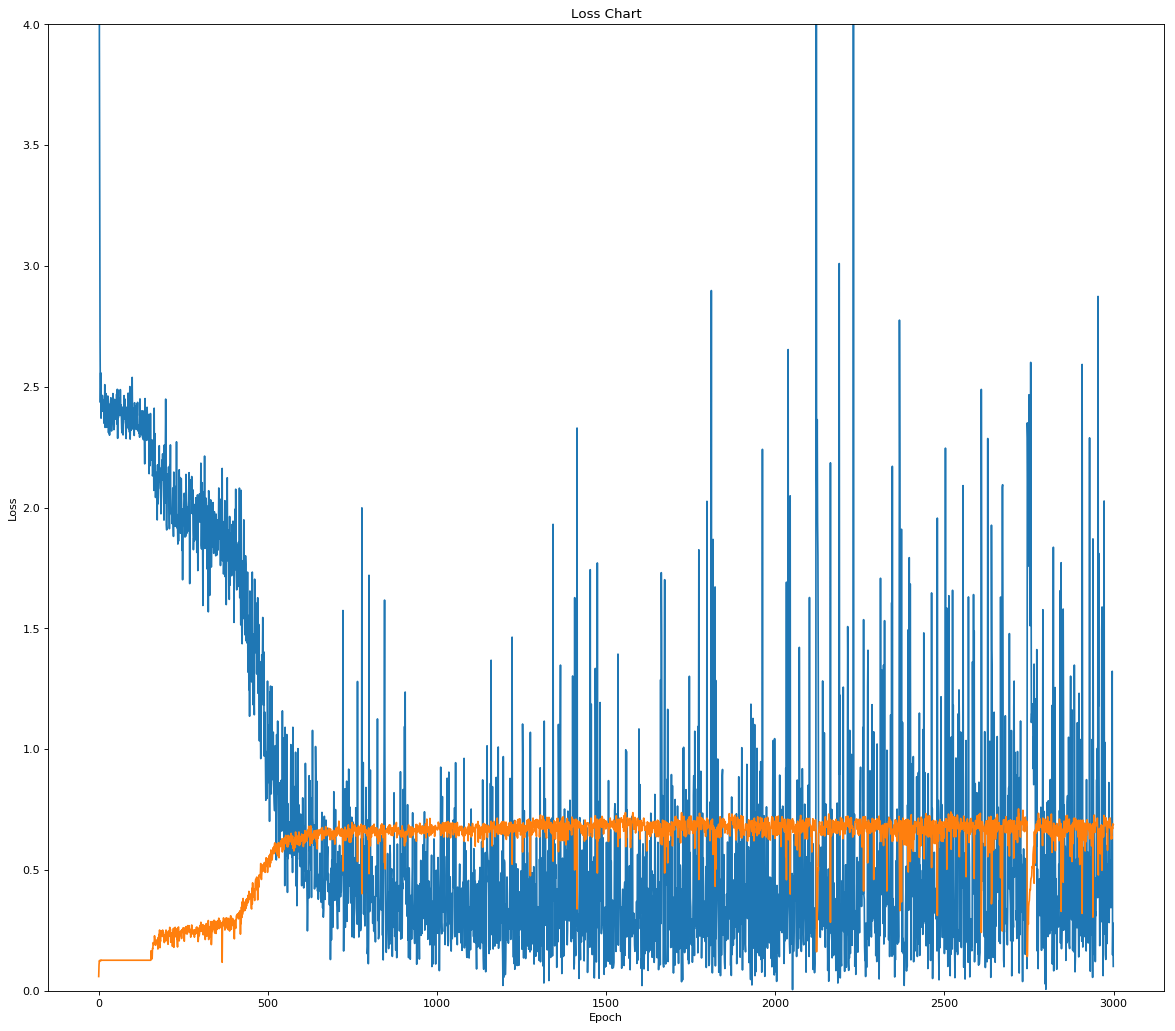

In [35]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.ylim(0,4)
plt.title('Loss Chart')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(plot_data)

In [36]:
outs_ = []
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('seedlings-model.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("Placeholder:0")
    for i in range(len(test_data)):
        feed ={x: [test_data[i][0]], hold_prob:1}

        op_to_restore = tf.nn.softmax(graph.get_tensor_by_name("add_3:0"))

        aaa = sess.run(op_to_restore, feed).ravel().tolist()
        aaa = aaa.index(max(aaa))
        print(dirs[aaa])
        outs_.append([test_data[i][1], dirs[aaa]])

INFO:tensorflow:Restoring parameters from ./seedlings-model.ckpt
Sugar beet
Loose Silky-bent
Small-flowered Cranesbill
Maize
Charlock
Common wheat
Common Chickweed
Charlock
Charlock
Maize
Cleavers
Shepherds Purse
Common Chickweed
Small-flowered Cranesbill
Loose Silky-bent
Fat Hen
Common Chickweed
Common Chickweed
Loose Silky-bent
Common Chickweed
Scentless Mayweed
Charlock
Loose Silky-bent
Loose Silky-bent
Sugar beet
Common Chickweed
Charlock
Charlock
Small-flowered Cranesbill
Loose Silky-bent
Common wheat
Small-flowered Cranesbill
Maize
Charlock
Black-grass
Loose Silky-bent
Charlock
Fat Hen
Fat Hen
Common Chickweed
Fat Hen
Loose Silky-bent
Loose Silky-bent
Fat Hen
Common Chickweed
Small-flowered Cranesbill
Common Chickweed
Small-flowered Cranesbill
Scentless Mayweed
Sugar beet
Common Chickweed
Maize
Common Chickweed
Maize
Shepherds Purse
Fat Hen
Scentless Mayweed
Common Chickweed
Common Chickweed
Scentless Mayweed
Loose Silky-bent
Maize
Common wheat
Loose Silky-bent
Charlock
Cleavers


Charlock
Black-grass
Small-flowered Cranesbill
Charlock
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Shepherds Purse
Small-flowered Cranesbill
Loose Silky-bent
Small-flowered Cranesbill
Common Chickweed
Charlock
Loose Silky-bent
Fat Hen
Fat Hen
Scentless Mayweed
Fat Hen
Common Chickweed
Loose Silky-bent
Sugar beet
Charlock
Fat Hen
Loose Silky-bent
Common Chickweed
Common Chickweed
Scentless Mayweed
Fat Hen
Common Chickweed
Cleavers
Loose Silky-bent
Loose Silky-bent
Fat Hen
Common Chickweed
Scentless Mayweed
Common Chickweed
Scentless Mayweed
Loose Silky-bent
Shepherds Purse
Small-flowered Cranesbill
Small-flowered Cranesbill
Loose Silky-bent
Shepherds Purse
Sugar beet
Loose Silky-bent
Small-flowered Cranesbill
Loose Silky-bent
Common Chickweed
Sugar beet
Scentless Mayweed
Loose Silky-bent
Maize
Maize
Small-flowered Cranesbill
Loose Silky-bent
Common Chickweed
Loose Silky-bent
Maize
Cleavers
Black-grass
Loose Silky-bent
Scentless Mayweed
Fat Hen
Loose Silky-bent
Sugar beet
Sugar b

## Writing csv submition

In [37]:
import csv
with open('submition.csv', 'w') as csvfile:
    fieldnames = ['file', 'species']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for i in range(len(outs_)):
        writer.writerow({'file': outs_[i][0], 'species':outs_[i][1]})
    print("csv file ready")

csv file ready
